In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl', context='notebook', ticks=True, grid=False, figsize=(10, 6))

In [2]:
from IPython.display import display, Markdown
from tqdm.notebook import tqdm

import random
import requests
import re
from copy import copy
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from gensim.models import Word2Vec, FastText

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

___

## Load and Merge

In [4]:
main_df = pd.read_pickle("data/main_df.pickle")

In [5]:
ingredient_df = pd.read_excel("data/ingredient_table.xlsx")
ingredient_df = ingredient_df[['제품명', '업체명', '주성분', '품목기준코드']].copy()

In [6]:
main_df['itemseq'] = main_df['itemseq'].astype(int)
merged_df = pd.merge(main_df, ingredient_df, left_on='itemseq', right_on='품목기준코드')

In [7]:
merged_df = merged_df[['itemname', 'entpname', 'efcyqesitm', 'usemethodqesitm', 'atpnqesitm',
       'itemseq', '주성분']]

merged_df.rename(columns={'주성분': 'ingredient'}, inplace=True)

In [8]:
merged_df.head()

,itemname,entpname,efcyqesitm,usemethodqesitm,atpnqesitm,itemseq,ingredient
0,활명수,동화약품(주),"<p>이 약은 식욕감퇴(식욕부진), 위부팽만감, 소화불량, 과식, 체함, 구역, 구...","<p>만 15세 이상 및 성인은 1회 1병(75 mL), 만 11세이상~만 15세미...",<p>만 3개월 미만의 젖먹이는 이 약을 복용하지 마십시오.</p>\n\n<p>이 ...,195700020,"건강,육두구,후박,진피,창출,현호색,L-멘톨,육계,정향,아선약,고추틴크"
1,신신티눈고(살리실산반창고)(수출명:SINSINCORNPLASTER),신신제약(주),"<p>이 약은 티눈, 못(굳은살), 사마귀에 사용합니다. </p>\n",<p>이형지로부터 벗겨 이 약제면을 환부(질환 부위)에 대고 테이프로 고정하고 2~...,"<p>이 약에 과민증 환자, 당뇨병, 혈액순환장애 환자는 이 약을 사용하지 마십시오...",195900034,살리실산
2,아네모정,삼진제약(주),"<p>이 약은 위산과다, 속쓰림, 위부불쾌감, 위부팽만감, 체함, 구역, 구토, 위...","<p>성인 1회 2정, 1일 3회 식간(식사와 식사때 사이) 및 취침시에 복용합니다...","<p>투석요법을 받고 있는 환자, 수유부, 만 7세 이하의 어린이, 갈락토오스 불내...",195900043,"탄산마그네슘,탄산수소나트륨,침강탄산칼슘,건조수산화알루미늄겔,스코폴리아엑스10배산"
3,타치온정50밀리그램(글루타티온(환원형)),동아제약(주),"<p>이 약은 약물중독, 자가중독에 사용합니다.</p>","<p>성인은 1회 1~2정(50~100 mg), 1일 1~3회 복용합니다.</p><...",,197100015,글루타티온(환원형)
4,겔포스현탁액(인산알루미늄겔),보령제약(주),"<p>이 약은 위.십이지장 궤양, 위염, 위산과다(속쓰림, 위통, 구역, 구토)의 ...","<p>성인은 1회 1포, 1일 3~4회 식간(식사때와 식사때 사이) 및 취침시 복용...","<p>이 약을 복용하기 전에 신장장애, 변비 환자는 의사 또는 약사와 상의하십시오....",197400207,"콜로이드성인산알루미늄,인산알루미늄겔"


___

## Preprocess the feature

In [9]:
def parser1(x) : 
    parsed = re.sub("\<.{,5}\>|\n|\xa0","",x)
    parsed = parsed.replace("·",',').replace("ㆍ",',')
    
    for _ in range(3) : 
        parsed = parser2(parsed)
        
    return re.sub("이 약은\s*|에 사용합니다.", '', parsed)

def parser2(data) : 
    return re.sub('\([\w\s\,]+\)','', data)

def symptom_parse(x) : 
    parsed = parser1(x)
    parsed = re.sub("([A-Z]{1}[1-9]{,1})\,", r'\g<1> &', parsed)
    parsed = parsed.replace("(",'').replace(")",'')
    return parsed

In [10]:
merged_df['symptom'] = merged_df.efcyqesitm.copy().map(symptom_parse)
merged_df['ingredient'] = merged_df.copy().ingredient.map(parser2).str.replace(" ",'')

prep_caution = list(map(lambda x : re.sub("\<.{,5}\>|\n|\xa0","",x), merged_df.atpnqesitm.copy()))
prep_caution = list(map(lambda x : re.sub('[^가-힣\s0-9]',' ', x), prep_caution))
merged_df['caution'] = prep_caution

prep_df = merged_df[['itemname', 'entpname', 'ingredient', 'symptom', 'caution']].copy()

In [11]:
prep_df['splitted_ingredient'] = prep_df.ingredient.str.split(",")
prep_df['splitted_symptom'] = prep_df.symptom.str.split(",").map(lambda x : list(map(lambda i : i.strip(), x)))
prep_df['tokenized_caution'] = list(map(lambda x : word_tokenize(x), prep_caution))

train_df = prep_df.drop_duplicates(['entpname', 'ingredient', 'symptom'])
train_df.shape, prep_df.shape

((4214, 8), (4470, 8))

In [12]:
mem = list()

for row in tqdm(train_df[['splitted_ingredient', 'splitted_symptom']].values) : 
    tmp = list()
    for i in row[0] : 
        for j in row[1] : 
            tmp.append([i,j])            
    mat = np.array(tmp)
    mem.append(mat)
    
data = np.vstack(mem)
data.shape

  0%|          | 0/4214 [00:00<?, ?it/s]

(123847, 2)

___

## Train the model
- pre-train the individual feature using fast-text
- learn projection model name Ingre2Symp model using skip-gram similar logic

1. pretrain

In [13]:
%%time

def augmentation(series, iters=5) : 
    mem = list()
    for _ in range(iters) : 
        tmp = series.map(lambda x : sorted(x, key=lambda k: random.random()))
        mem.append(tmp)
    train = pd.concat(mem, ignore_index=True)
    return train

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 28.6 µs


In [14]:
symptom_w2v = FastText(augmentation(train_df.splitted_symptom).tolist(), vector_size=20, epochs=5*2)
ingre_w2v = FastText(augmentation(train_df.splitted_ingredient).tolist(), vector_size=20, epochs=5*2)
caut_w2v = FastText(train_df.tokenized_caution.tolist(), vector_size=50, epochs=5*1)

2. Indexing to train the torch model

In [15]:
ingre_lemma_dict = {val:idx for idx, val in enumerate(ingre_w2v.wv.index_to_key)}
symp_lemma_dict = {val:idx for idx, val in enumerate(symptom_w2v.wv.index_to_key)}

indexed = np.stack([list(map(lambda x : ingre_lemma_dict.get(x), data[:,0])), list(map(lambda x : symp_lemma_dict.get(x), data[:,1]))]).T
indexed = indexed[np.isfinite(indexed).all(1)]
np.random.shuffle(indexed)

In [16]:
ingre_emb = np.random.random(size=(len(ingre_lemma_dict), ingre_w2v.wv.vector_size))
symp_emb = np.random.random(size=(len(symp_lemma_dict), symptom_w2v.wv.vector_size))

for word, wi in ingre_lemma_dict.items() : 
    ingre_emb[wi] = ingre_w2v.wv.get_vector(word)
    
for word, wi in symp_lemma_dict.items() : 
    symp_emb[wi] = symptom_w2v.wv.get_vector(word)
    
ingre_emb = torch.tensor(ingre_emb)
symp_emb = torch.tensor(symp_emb)

3. modeling

### simple linear projection layer
- 논문 참조 : [Exploiting Similarities among Languages for Machine Translation](https://arxiv.org/pdf/1309.4168.pdf)
- ingredient 와 symptom feature 는 서로를 label 로 사용될 수 있기 때문에 각 vector space 를 projection 을 통해 communicate 하게 만든다. 이는 dictionary form 의 bi-lingual word embedding 학습과 유사한 form 으로 해석될 수 있다.
- 논문에서는 projection layer $W_{L}$ 만 학습하는데 그 이유는 개별 embedding vector 가 well pre-trained 되었다고 가정하기 때문이다. 난 projection layer 를 사용하는 것이 아닌, 더 나은 embedding 을 학습하길 바라므로, 각 embedding layer 까지 학습에 포함시킨다. 

In [17]:
class Ingre2Symp(nn.Module) : 
    def __init__(self, ingre_vocab_size, symp_vocab_size, hidden_dim, ingre_pretrained=None, symp_pretrained=None) :
        super().__init__()
        
        if ingre_pretrained is not None :
            self.encoder1 = nn.Embedding.from_pretrained(ingre_pretrained, freeze=False)
        else : 
            self.encoder1 = nn.Embedding(ingre_vocab_size, hidden_dim)
        if symp_pretrained is not None: 
            self.encoder2 = nn.Embedding.from_pretrained(symp_pretrained, freeze=False)
        else : 
            self.encoder2 = nn.Embedding(symp_vocab_size, hidden_dim)
            
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, src, trg) : 
        encoded1 = self.fc(self.encoder1(src).type(torch.FloatTensor))
        encoded2 = self.encoder2(trg)
        return encoded1, encoded2

In [18]:
net = Ingre2Symp(ingre_vocab_size=len(ingre_lemma_dict),
          symp_vocab_size=len(symp_lemma_dict),
           hidden_dim=ingre_w2v.wv.vector_size,
           ingre_pretrained=ingre_emb,
           symp_pretrained=symp_emb)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

epoch = 10
batch_size = 100

pretrained_losses = list()

for proc in tqdm(range(epoch)) : 
    
    np.random.shuffle(indexed)
    
    batch_losses = list()
    for batch_idx in range(batch_size, indexed.shape[0], batch_size) : 

        start_idx = batch_idx-batch_size
        end_idx = batch_idx

        src = torch.tensor(indexed[start_idx:end_idx,0])
        trg = torch.tensor(indexed[start_idx:end_idx,1])
        
        e1 ,e2 = net(src, trg)

        optimizer.zero_grad()
        loss = criterion(e1, e2.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    pretrained_losses.append(np.mean(batch_losses))

  0%|          | 0/10 [00:00<?, ?it/s]

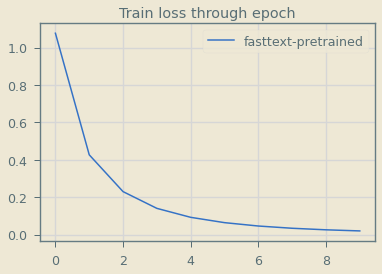

In [19]:
plt.title("Train loss through epoch")
plt.plot(pretrained_losses, label='fasttext-pretrained')

plt.legend()
plt.grid()
plt.show()

____

In [21]:
finetuned_ingre_vec = net.encoder1.weight.data.numpy()
projected_finetuned_ingre_vec = net.fc(net.encoder1.weight.type(torch.FloatTensor)).data.numpy()
finetuned_symp_vec = net.encoder2.weight.data.numpy()

_____

## Merge vector to build medicine vector

In [22]:
symptom_vector = np.full(shape=(prep_df.shape[0], symptom_w2v.wv.vector_size), fill_value=np.nan)

for idx, ls in tqdm(enumerate(prep_df.splitted_symptom.values), total=len(prep_df)) : 
    wc = 0
    vector = np.zeros(shape=(symptom_w2v.wv.vector_size,))
    
    for word in ls : 
        wi = symp_lemma_dict.get(word)
        if wi is not None : 
            wv = finetuned_symp_vec[wi]
        else : 
            continue
        wc += 1
        vector += wv
    vector /= wc
    symptom_vector[idx] = vector

  0%|          | 0/4470 [00:00<?, ?it/s]

In [23]:
ingredient_vector = np.full(shape=(prep_df.shape[0], ingre_w2v.wv.vector_size), fill_value=np.nan)

for idx, ls in tqdm(enumerate(prep_df.splitted_ingredient.values), total=len(prep_df)) : 
    wc = 0
    vector = np.zeros(shape=(ingre_w2v.wv.vector_size,))

    for word in ls : 
        wi = ingre_lemma_dict.get(word)
        if wi is not None : 
            wv = projected_finetuned_ingre_vec[wi]
        else : 
            continue
#         wv = symptom_w2v.wv.get_vector(word)
        wc += 1
        vector += wv
    vector /= wc
    ingredient_vector[idx] = vector

  0%|          | 0/4470 [00:00<?, ?it/s]

In [24]:
caution_vector = np.full(shape=(prep_df.shape[0], caut_w2v.wv.vector_size), fill_value=0.)

for idx, ls in tqdm(enumerate(prep_df.tokenized_caution.values), total=len(prep_df)) : 
    wc = 0
    vector = np.zeros(shape=(caut_w2v.wv.vector_size,))
    
    for word in ls : 
        wv = caut_w2v.wv.get_vector(word)
        wc += 1
        vector += wv
    if wc == 0 :
        print("There was no word at {}th row!".format(idx))
    else : 
        vector /= wc
        caution_vector[idx] = vector

  0%|          | 0/4470 [00:00<?, ?it/s]

There was no word at 3th row!
There was no word at 18th row!
There was no word at 105th row!
There was no word at 124th row!
There was no word at 134th row!
There was no word at 135th row!
There was no word at 3094th row!
There was no word at 3270th row!


___

## Vector Stats check before concatenate

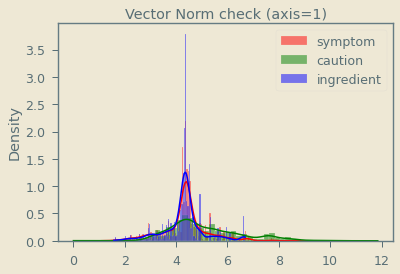

In [25]:
plt.title("Vector Norm check (axis=1)")
sns.histplot(np.linalg.norm(symptom_vector, axis=1), label='symptom', stat='density', color='red', alpha=0.5, kde=True)
sns.histplot(np.linalg.norm(caution_vector, axis=1), label='caution', stat='density', color='green', alpha=0.5, kde=True)
sns.histplot(np.linalg.norm(ingredient_vector, axis=1), label='ingredient', stat='density', color='blue', alpha=0.5, kde=True)

plt.legend()
plt.show()

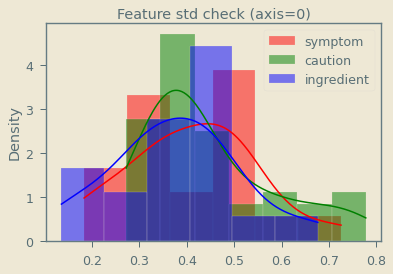

In [26]:
plt.title("Feature std check (axis=0)")

sns.histplot(np.std(symptom_vector, axis=0), label='symptom', stat='density', color='red', alpha=0.5, kde=True)
sns.histplot(np.std(caution_vector, axis=0), label='caution', stat='density', color='green', alpha=0.5, kde=True)
sns.histplot(np.std(ingredient_vector, axis=0), label='ingredient', stat='density', color='blue', alpha=0.5, kde=True)

plt.legend()
plt.show()

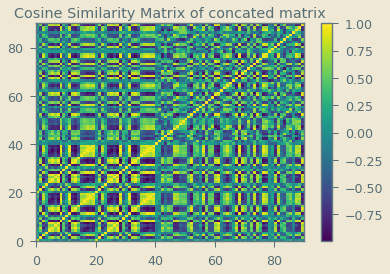

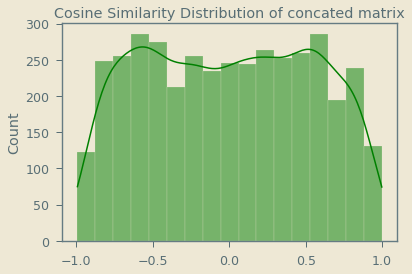

In [27]:
cossim_mat = cosine_similarity(np.hstack([normalize(symptom_vector), normalize(ingredient_vector), normalize(caution_vector)]).T)

plt.title("Cosine Similarity Matrix of concated matrix")
plt.pcolor(cossim_mat)
plt.colorbar()
plt.show()

plt.title("Cosine Similarity Distribution of concated matrix")
cossim_mat[np.tril_indices_from(cossim_mat)] = np.nan
sns.histplot(cossim_mat[np.isfinite(cossim_mat)], kde=True, color='green')
plt.show()

___

# Concat & Cluster

In [28]:
stacked_vector = np.hstack([normalize(symptom_vector),
                            normalize(ingredient_vector), normalize(caution_vector)])

In [29]:
U, S, Vt = np.linalg.svd(stacked_vector-np.mean(stacked_vector, 0))

cumul_var_ratio = np.cumsum((S**2)/np.sum(S**2))
truncate_idx = np.where(cumul_var_ratio > 0.9)[0].min()
truncate_idx

11

In [30]:
reduced_emb = np.dot(stacked_vector - np.mean(stacked_vector, 0), Vt[:truncate_idx].T)

In [31]:
ncl = 1000 # determined by silhouette score
label = AgglomerativeClustering(ncl).fit_predict(normalize(reduced_emb))

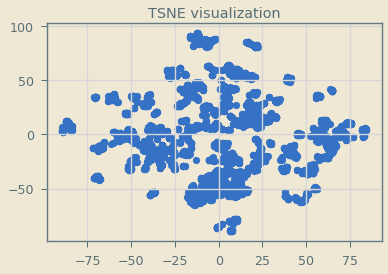

In [32]:
tsne_emb = TSNE(2).fit_transform(reduced_emb)

plt.title("TSNE visualization")
plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
plt.grid()
plt.show()

In [33]:
def calc_cossim_arr(x) : 
    cossim_arr = cosine_similarity(x)
    cossim_arr[np.tril_indices_from(cossim_arr)] = np.nan
    return np.nanmean(cossim_arr)

In [34]:
vis_cnt = 5
cnt = 0

for l in np.unique(label) :
    bool_ = label == l    
    allocated_df = prep_df.loc[bool_].iloc[:, [0,1,2,3,4]]
    
    if allocated_df.shape[0] == 1 : 
        continue
    
    display(allocated_df.head(3)) # only looks 3 of them
    display(Markdown("_________"))
    
    cnt += 1
    if cnt > vis_cnt : 
        break

,itemname,entpname,ingredient,symptom,caution
1693,마그스포르테액,조아제약(주),"글리세로인산마그네슘,피리독신염산염","임신,수유기, 병중,병후의 체력 저하 시 비타민 B6의 보급과 구각염, 구순염, 구...",이 약에 과민증 환자 만 12개월 미만의 젖먹이 심한 증상의 신부전 환자는이 약...
3129,마그스파워액,조아제약(주),"글리세로인산마그네슘,피리독신염산염","임신,수유기, 병중,병후의 체력 저하 시 비타민 B6의 보급과 마그네슘결핍으로 인한...",이 약에 과민증 환자 만 12개월 미만의 젖먹이 심한 증상의 심부전 환자는 이 약...
3402,광동벤포파워액,광동제약(주),"니코틴산아미드,피리독신염산염,우르소데옥시콜산,리보플라빈,산화아연,벤포티아민","육체피로, 임신,수유기, 병중,병후의 체력 저하 시 비타민 B1 & B2 & B6의...",이 약에 과민증 환자 만 12개월 미만의 젖먹이 페닐케톤뇨증 환자는 이 약을 복...


_________

,itemname,entpname,ingredient,symptom,caution
294,복합엘씨500연질캡슐(수출명:MEGA-NAMIC),구주제약(주),"L-시스틴,콜린타르타르산염",간기능 저하로 인한 소화불량의 보조치료,대두유 콩 땅콩에 과민증 환자 또는 경험자 중증의 간세포기능부전이나 담도폐색 ...
468,헤파엘연질캡슐,코오롱제약(주),"L-시스틴,콜린타르타르산염",간기능 저하로 인한 소화불량의 보조치료,중증의 간세포기능부전이나 담도폐색 환자는 이 약을 복용하지 마십시오 이 약을 복용하...
506,씨씨콤연질캡슐(수출명 : Biosliver Soft Cap.),한국코러스(주),"L-시스틴,콜린타르타르산염",간기능 저하로 인한 소화불량의 보조치료,중증의 간세포기능부전이나 담도폐색 환자는 이 약을 복용하지 마십시오 이 약을 복용하...


_________

,itemname,entpname,ingredient,symptom,caution
3173,로이코비에스액,고려제약(주),"니코틴산아미드,폴리네이트칼슘,피리독신염산염,리보플라빈포스페이트나트륨,덱스판테놀,시아...","거대적아구성 빈혈 치료 보조 또는 임신, 분만 후, 수유 시, 병후 회복기, 특정 ...",이 약에 과민증 환자 만 3개월 미만의 젖먹이 암 환자는 이 약을 복용하지 마십...
3351,액티넘이엑스골드정,한국다케다제약(주),"폴산,피리독살포스페이트수화물,d-α-토코페롤숙시네이트,푸르설티아민염산염,메코발라민,...","눈의 피로, 근육통,관절통, 신경통, 손발의 저림 증상의 완화",이 약에 과민증 환자 15세 미만의 소아는 이 약을 복용하지 마십시오 이 약을 복...


_________

,itemname,entpname,ingredient,symptom,caution
2566,메가트루골드정,(주)유한양행,"니코틴산아미드,폴산,셀레늄함유건조효모,콘드로이틴설페이트나트륨,피리독신염산염,아스코르...","육체피로, 임신,수유기, 병중,병후의 체력 저하 시, 발육기, 노년기의 비타민 A ...",고칼슘혈증 유육종증 신장질환 이 약에 과민증 환자 만 12개월 미만의 젖먹이...
2866,아로나민실버프리미엄정,일동제약(주),"니코틴산아미드,폴산,시아노코발라민1000배산,셀레늄함유건조효모,무수인산수소칼슘,콘드...","육체피로, 임신,수유기, 병중,병후의 체력 저하 시, 발육기, 노년기의 비타민 A ...",고칼슘혈증 유육종증 신장질환 이 약에 과민증 환자 만 12개월 미만의 젖먹이...
3046,센티렉스실버어드밴스정,(주)글락소스미스클라인컨슈머헬스케어코리아,"아스코르브산97%과립,폴산,무수인산수소칼슘,탄산칼슘95%과립,콜레칼시페롤혼합물,피리...","육체피로, 임신,수유기, 병중,병후의 체력 저하 시, 발육기, 노년기의 비타민의 보...",고칼슘혈증환자 유육종증 신장질환 이 약에 과민증 환자 만 12개월 미만의 젖...


_________

,itemname,entpname,ingredient,symptom,caution
1001,젤존팝카타플라스마(플루르비프로펜),(주)오현파마코푸레이션,플루르비프로펜,"퇴행성관절염, 어깨관절주위염, 건,건초염, 상완골상과염, 근육통, 외상후의 종창,동...",이 약에 과민증 경험자 아스피린 천식 비스테로이드성 소염진통제 등에 의한 천식발작 ...
1003,조아팝(플루르비프로펜),(주)재우스팜,플루르비프로펜,"퇴행성관절염, 어깨관절주위염, 건,건초염, 상완골상과염, 근육통, 외상후의 종창,동...",이 약에 과민증 경험자 아스피린 천식 비스테로이드성 소염진통제 등에 의한 천식발작 ...
1116,다나펜카타플라스마(플루르비프로펜),(주)오현파마코푸레이션,플루르비프로펜,"퇴행성관절염, 어깨관절주위염, 건,건초염, 상완골상과염, 근육통, 외상후의 종창,동...",이 약에 과민증 경험자 아스피린 천식 비스테로이드성 소염진통제 등에 의한 천식발작 ...


_________

,itemname,entpname,ingredient,symptom,caution
1150,토비에스크림,알리코제약(주),"dl-캄파,디부카인염산염,에녹솔론,디펜히드라민,l-멘톨","벌레 물린데, 피부가려움, 습진, 두드러기, 피부염, 땀띠, 동창",30개월 이하의 유아는 이 약을 사용하지 마십시오 이 약을 사용하기 전에 약 또는 ...
1840,버물리키드크림,현대약품(주),"토코페롤아세테이트,덱스판테놀,글리시리진산이칼륨,디펜히드라민","가려움, 피부염, 습진, 두드러기, 땀띠, 동상, 벌레 물림, 짓무름",생후 1개월 미만의 소아는 이 약을 사용하지 마십시오 이 약을 사용하기 전에 알레르...
1905,버래물액,신신제약(주),"dl-캄파,디부카인염산염,디펜히드라민염산염,에녹솔론,l-멘톨","습진, 피부염, 땀띠, 옻 등에 의한 피부염, 가려움, 벌레물린데, 두드러기",30개월 이하의 유아 창상 상처 면 눈 주위 점막에는 사용하지 마십시오 이 약...


_________

In [35]:
mem = list()

for l in np.unique(label) :
    bool_ = label == l

    allocated_iv = ingredient_vector[bool_].copy()
    allocated_sv = symptom_vector[bool_].copy()
    allocated_cv = caution_vector[bool_].copy()
    
    if allocated_iv.shape[0] <= 1 : 
        continue

    ic, sc, cc = map(lambda x : np.round(calc_cossim_arr(x),3), [allocated_iv, allocated_sv, allocated_cv])
    mem.append((ic, sc, cc))

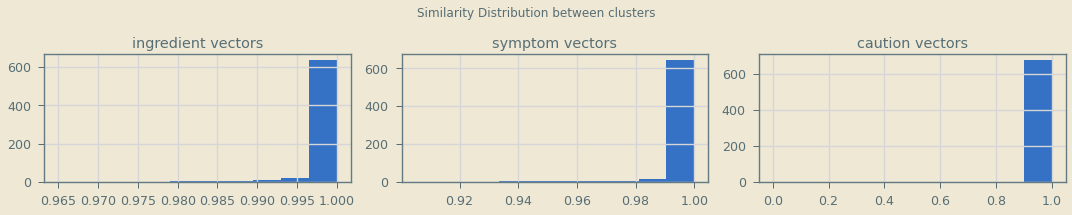

In [36]:
fig, axs = plt.subplots(1,3, figsize=(15,3))
flattened_axs = axs.ravel()

fig.suptitle("Similarity Distribution between clusters")
for fn, idx in zip(['ingredient', 'symptom', 'caution'], range(len(mem[0]))) : 
    flattened_axs[idx].set_title("{} vectors".format(fn))
    flattened_axs[idx].hist(list(map(lambda x : x[idx], mem)), bins=10)
    flattened_axs[idx].grid()
fig.tight_layout()
fig.show()

___

# Test 1

In [37]:
iv = ingredient_vector.copy()
sv = symptom_vector.copy()
cv = caution_vector.copy()

cossim_iv = cosine_similarity(iv)
cossim_sv = cosine_similarity(sv)
cossim_cv = cosine_similarity(cv)

cossim_iv[np.tril_indices_from(cossim_iv)] = np.nan
cossim_sv[np.tril_indices_from(cossim_sv)] = np.nan
cossim_cv[np.tril_indices_from(cossim_cv)] = np.nan

cossim_iv_vec = cossim_iv[np.isfinite(cossim_iv)]
cossim_sv_vec = cossim_sv[np.isfinite(cossim_sv)]
cossim_cv_vec = cossim_cv[np.isfinite(cossim_cv)]

In [38]:
mem = list()

for _ in tqdm(range(100)) : 
    sampled_idx = np.random.choice(np.arange(cossim_iv_vec.shape[0]), 1000, replace=False)
    sampled_cossim_iv_vec, sampled_cossim_sv_vec, sampled_cossim_cv_vec = \
    cossim_iv_vec[sampled_idx], cossim_sv_vec[sampled_idx], cossim_cv_vec[sampled_idx]
    sampled_correl_mat = np.corrcoef([sampled_cossim_iv_vec, sampled_cossim_sv_vec, sampled_cossim_cv_vec])
    mem.append(sampled_correl_mat)

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
samples = np.nan_to_num(np.stack(mem))
std_ = samples.std(0)/samples.shape[0]
mean_ = samples.mean(0)
z = 1.96

In [40]:
display(Markdown("### Lower confidence interval of correlation"))
display(pd.DataFrame(mean_-z*std_, index=['ingredient', 'symptom', 'caution'],
            columns=['ingredient', 'symptom', 'caution']))

display(Markdown("### Higher confidence interval of correlation"))
display(pd.DataFrame(mean_+z*std_, index=['ingredient', 'symptom', 'caution'],
            columns=['ingredient', 'symptom', 'caution']))

### Lower confidence interval of correlation

,ingredient,symptom,caution
ingredient,1.000000,0.915687,0.003631
symptom,0.915687,1.000000,0.026337
caution,0.003631,0.026337,1.000000


### Higher confidence interval of correlation

,ingredient,symptom,caution
ingredient,1.000000,0.91610,0.004717
symptom,0.916100,1.00000,0.027530
caution,0.004717,0.02753,1.000000


# Note

[project 1](https://github.com/hskimim/medicine2vec/blob/master/clustering.ipynb) 과 비교했을 때, correlation 이 1.5배에서 2배정도로 상승한 것을 볼 수 있다. 흥미로운 점은, 모델 학습에 사용되지 않은 caution feature 의 correlation 또한 증가한 것이다.

____

## Test 2

In [41]:
def stat_test(vec, iters=30) : 
    cossim_symptom = cosine_similarity(vec[bool_])
    cossim_symptom[np.tril_indices_from(cossim_symptom)] = np.nan
    null_sim = np.nanmean(cossim_symptom)
    
    alternative_sim = 0
    for i in range(iters) : 
        cossim_symptom = cosine_similarity(vec[not_index_])
        cossim_symptom[np.tril_indices_from(cossim_symptom)] = np.nan
        alternative_sim += np.nanmean(cossim_symptom)
        
    return null_sim, alternative_sim/iters

In [42]:
nm_ls, vec_ls = ['ingredient', 'symptom', 'caution'], [ingredient_vector, symptom_vector, caution_vector]
ncl = 500 # arbitrarily determined, same with project 1

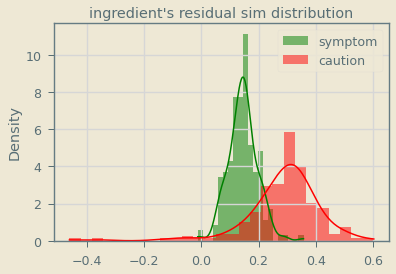

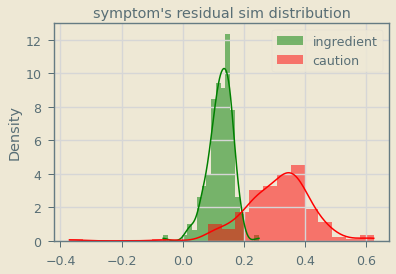

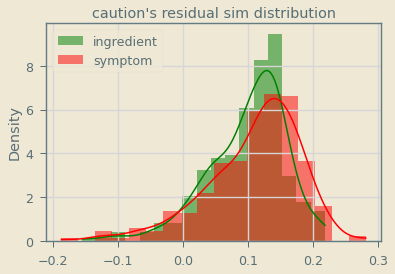

In [43]:
for idx in range(len(nm_ls)) : 
    
    stacked_vector = normalize(vec_ls[idx])
    U, S, Vt = np.linalg.svd(stacked_vector-np.mean(stacked_vector, 0))

    cumul_var_ratio = np.cumsum((S**2)/np.sum(S**2))
    truncate_idx = np.where(cumul_var_ratio > 0.9)[0].min()
    reduced_emb = np.dot(stacked_vector - np.mean(stacked_vector, 0), Vt[:truncate_idx].T)
    
    label = AgglomerativeClustering(ncl).fit_predict(normalize(reduced_emb))

    alt_ls1, alt_ls2 = list(), list()
    not_target_index = np.arange(len(nm_ls))[~np.in1d(np.arange(len(nm_ls)), idx)]
    
    for l in np.unique(label) :    
        bool_ = label == l
        if bool_.sum() < 5 : 
            continue
        not_index_ = np.random.choice(np.where(~bool_)[0], bool_.sum(), replace=False)

        null_alt1,alternative_alt1 = stat_test(vec_ls[not_target_index[0]])
        null_alt2,alternative_alt2 = stat_test(vec_ls[not_target_index[1]])

        diff1 = null_alt1 - alternative_alt1
        diff2 = null_alt2 - alternative_alt2

        alt_ls1.append(diff1)
        alt_ls2.append(diff2)

    sns.histplot(alt_ls1, color="green", label=nm_ls[not_target_index[0]], kde=True, stat="density", linewidth=0)
    sns.histplot(alt_ls2, color="red", label=nm_ls[not_target_index[1]], kde=True, stat="density", linewidth=0)
    
    plt.title("{}'s residual sim distribution".format(nm_ls[idx]))
    plt.grid()
    plt.legend()
    plt.show()

# Note

흥미로운 부분을 발견하였는데, 위에서 진행한 모델링은 ingredient vector 를 projection 을 통해, symptom vector 를 닮아가게 한 것이다. 이 때문인지, symptom 을 clustering 해서 본 ingredient feature 의 discrimination power 가 상승한 것을 확인할 수 있었다. 하지만, 이에 반해, 그 반대의 경우는 performance 가 줄어들었다. [[비교]](https://github.com/hskimim/medicine2vec/blob/master/clustering.ipynb)

이에 따라, ingredient $\rightarrow$ symptom 와 symptom $\rightarrow$ ingredient 에 대해 양방향 학습을 하게 되면, modeling 에 사용된 feature 에 대해 모두 더 좋은 결과를 기대할 것이라는 가정에 이른다. 이는 project 2의 sub-section 으로 다른 notebook에서 다루도록 하겠다.